In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from glob import glob
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import sympy as sp

In [2]:
def light_curve(lc_dir,look=False):
    data = np.genfromtxt(lc_dir,names="time,flux,et,ef")
    good = (data['ef'] == 0)
    time_diff = data['time'][good][1:] - data['time'][good][:-1]
    
    if (np.max(time_diff) < 10):
        error_point = np.argmax(time_diff)
        
        time = data['time'][good]
        flux = data['flux'][good]
        et = data['et'][good]
#         time = np.append(data['time'][good][10:error_point-15],data['time'][good][error_point+20:-10])
#         flux = np.append(data['flux'][good][10:error_point-15],data['flux'][good][error_point+20:-10])
#         et = np.append(data['et'][good][10:error_point-15],data['et'][good][error_point+20:-10])
        
#         min_flux = np.min(np.append(flux[int(len(flux)*0.05):int(len(flux)*0.4)],\
#                                     flux[int(len(flux)*0.6):-int(len(flux)*0.05)]))
        
#         norm_flux = (flux - np.median(flux))/(np.median(flux) - min_flux)
        norm_flux = flux/np.median(flux)
#         norm_et = et / np.abs(np.median(flux) - min_flux)
        norm_et = et/np.abs(np.median(flux))
#         w = (norm_flux < 0.1) & (norm_flux > -1.2)
        w = (norm_flux < 1.03) & (norm_flux > 0.75)

        if look == True:
            plt.figure(figsize=(10,5))
            plt.plot(time[w],norm_flux[w],'c')
            plt.plot(time[w],norm_flux[w],'r.')
            plt.xlabel('time');plt.ylabel('flux')
            plt.grid()
            plt.tight_layout()
            plt.show()
        else:
            None
        

        return time[w],norm_flux[w],norm_et[w]

    else:
        return "bad_data","bad_data","bad_data"



def mulit_light_curve(lc_dir,look=False):
    time = []; flux = []; et = []
    size = 0
    for i in range(10):
        test_dir = lc_dir[:-9] + "0%s" %i + "_LC.txt"
        if os.path.exists(test_dir) == True:
            t,f,e = light_curve(test_dir)
            if t == 'bad_data':
                None
            else:
                time.extend(t)
                flux.extend(f)
                et.extend(e)
                size += 1
        else:
            None

    for i in range(10):
        test_dir = lc_dir[:-9] + "1%s" %i + "_LC.txt"
        if os.path.exists(test_dir) == True:
            t,f,e = light_curve(test_dir)
            if t == 'bad_data':
                None
            else:
                time.extend(t)
                flux.extend(f)
                et.extend(e)
                size += 1
        else:
            None
            
    if size > 2:
        if look == True:
            plt.figure(figsize=(5*size,5))
            plt.plot(time,flux,'c')
            plt.plot(time,flux,'r.')
            plt.xlabel('time');plt.ylabel('flux')
            plt.grid()
            plt.show()
        else:
            None
    else:
        None

    return time, flux, et

In [3]:
def first_poly(x,a,b):
    y = a*x+b
    return y

def sec_poly(x,a,b,c):
    y = a*x**2+b*x+c
    return y

def fourth_poly(x,a,b,c,d,e):
    y = a*x**4+b*x**3+c*x**2+d*x+e
    return y

def sixth_poly(x,a,b,c,d,e,f,g):
    y = a*(x**6) + b*(x**5) + c*(x**4) + d*(x**3) + e*(x**2) + f*x + g
    return y

def root_4th_poly(a,b,c,d):
    x = sp.Symbol('x')
    f = 4*a*(x**3) + 3*b*(x**2) + 2*c*(x) + d
    root = sp.solve(f)
    r = [complex(root[0]).real,complex(root[1]).real,complex(root[2]).real]
    mid = r[np.argmin(np.abs(r))]
    return mid

In [4]:
def Phase_cycle(t,P,T_0):
    T_diff = np.array(t) - T_0
    I = np.round(T_diff/P)
    phi = (T_diff/P) - I
    return phi, I #phase and cycle


def sing_dc_func(guess_P,time,norm_flux,fir_eci,look=False):
    phi, I = Phase_cycle(time, guess_P, (fir_eci))
    phase_flux = np.stack((phi,norm_flux),axis=-1)
    phase_flux = np.array(sorted(phase_flux,key=lambda x:x[0]))
    phase = phase_flux[:,0]
    flux = phase_flux[:,1]

    if look == True:
        plt.figure(figsize=(15,5))
        plt.title('period = %s'%(guess_P))
        plt.plot(phase,flux,'c-')
        plt.plot(phase,flux,'r.')
        plt.xlabel('phase');plt.ylabel('flux')
        plt.grid()
        plt.show()        
    
    S = np.fabs(flux[-1] - flux[0]) + np.sum(np.fabs(flux[1:] - flux[:-1]))
    return S/47.-2.,phase,flux

In [5]:
def find_eclipse_single(lc_dir,period,eci_pos,look=False): #eci_pos is an array of each ecilpse time
    time, flux, et = mulit_light_curve(lc_dir)
    time = np.array(time); flux = np.array(flux); et = np.array(et) #set list to array
    ck_time = np.array(eci_pos)
    p_time = []; p_flux = []
    
    size = int(np.sqrt(len(ck_time)))+1
    plt.figure(figsize=(3*size,3*size))
    for i in range(len(ck_time)):
        tn = ck_time[i]
        tr = ((tn - 0.05*period) < time) & (time < (tn + 0.05*period)) #create a box around eclipse to fit
        if len(time[tr] > 5):
            mid_pos = np.argmin(flux[tr]) #mid eclipse position in time range
            left_pos = 0;right_pos = 0; 
            while (flux[tr][mid_pos-left_pos] < 0.99) & ((left_pos + 2) < mid_pos):
                left_pos += 1
            while (flux[tr][mid_pos+right_pos] < 0.99) & ((right_pos + 2) < (len(flux[tr]) - mid_pos)):
                right_pos += 1
            lp = mid_pos-left_pos #left eclipse position in time range
            rp = mid_pos+right_pos #right eclipse position in time range

            duration = right_pos+left_pos #number of point during eclipse
            if (left_pos > 1) & (right_pos > 1):
                x = time[tr][lp:rp] - time[tr][mid_pos]
                y = flux[tr][lp:rp]
                testx = np.linspace(x-0.05,x+0.05,100)
                if duration < 5: #  2nd poly fitting
                    popt, pcov = curve_fit(sec_poly, x, y, p0=[100,0,-0.5])
                    if popt[0] <= 0:
                        continue
                    peak_x = -0.5*popt[1]/popt[0]
                    peak_y = sec_poly(peak_x,popt[0],popt[1],popt[2])
                    testy = sec_poly(testx,popt[0],popt[1],popt[2])
                    # uncertainty
                    peak_ex = np.sqrt((1/popt[0])**2*pcov[1,1]**2+(popt[1]/popt[0]**2)**2*pcov[0,0]**2)
                    
                else: #  4th poly fitting
                    popt, pcov = curve_fit(fourth_poly, x, y, p0=[1,1,1,1,1])
                    peak_x = root_4th_poly(popt[0],popt[1],popt[2],popt[3])
                    peak_y = fourth_poly(peak_x,popt[0],popt[1],popt[2],popt[3],popt[4])
                    testy = fourth_poly(testx,popt[0],popt[1],popt[2],popt[3],popt[4])  
                      #  6th poly fitting
#                     popt, pcov = curve_fit(sixth_poly, x, y, p0=[1,1,1,1,1,1,1])
#                     peak_x = 0
#                     peak_y = flux[tr][mid_pos]
#                     testy = sixth_poly(testx,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
                    

                p_time.append(peak_x+time[tr][mid_pos]) # fitting time record
                p_flux.append(peak_y)
               
                plt.subplot(3,3,i+1)
                plt.plot(testx+time[tr][mid_pos],testy,'c-')
                plt.plot(peak_x+time[tr][mid_pos],peak_y,'ko')
                plt.plot(time[tr],flux[tr],'r.')
                plt.ylim(peak_y-0.01,1.01)
                plt.grid()
                plt.tight_layout()
    plt.show()
                
#################  check peak position ####################

    if look == True:
        plt.figure(figsize=(25,5))
        plt.plot(time,flux,'c.-')
        plt.plot(p_time,p_flux,'rx')
        plt.xlabel('time')
        plt.ylabel('normlized flux')
        plt.ylim(0.91,1.01)
        plt.show()
    
###########################################################
    
    return p_time

/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200_SEC002_LC.txt


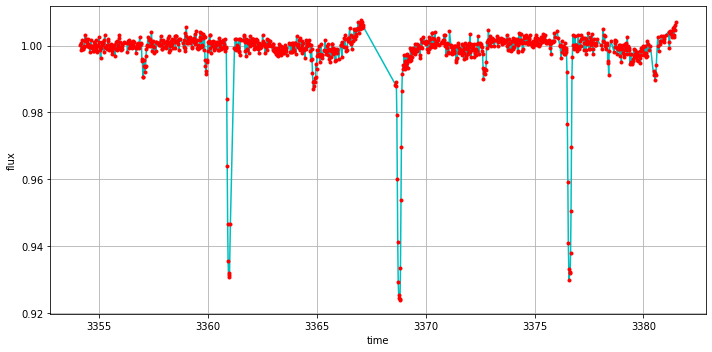

/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200_SEC003_LC.txt


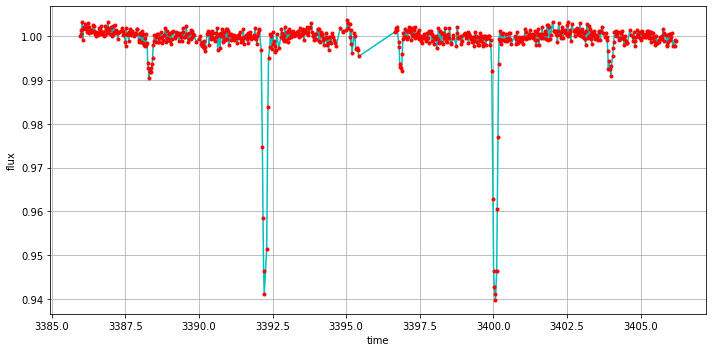

/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200_SEC005_LC.txt


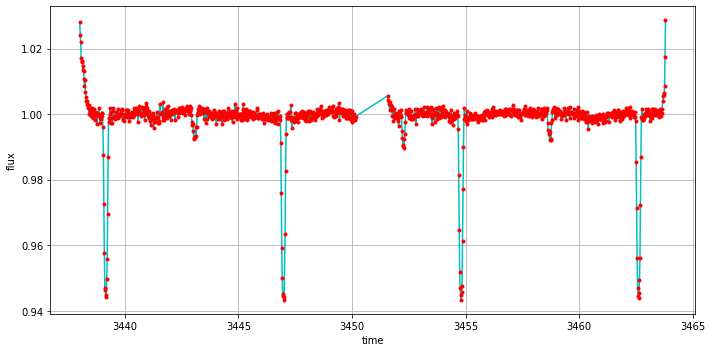

/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200_SEC006_LC.txt


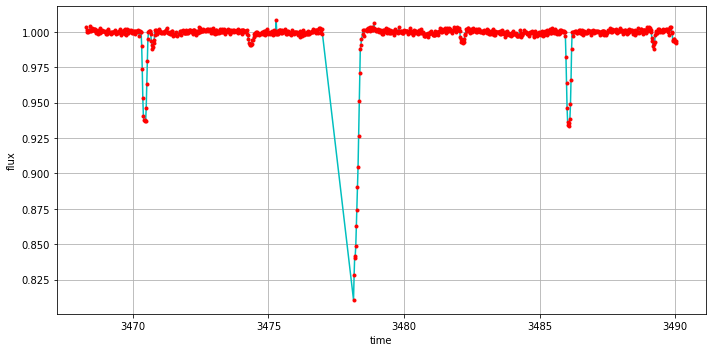

/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200_SEC007_LC.txt


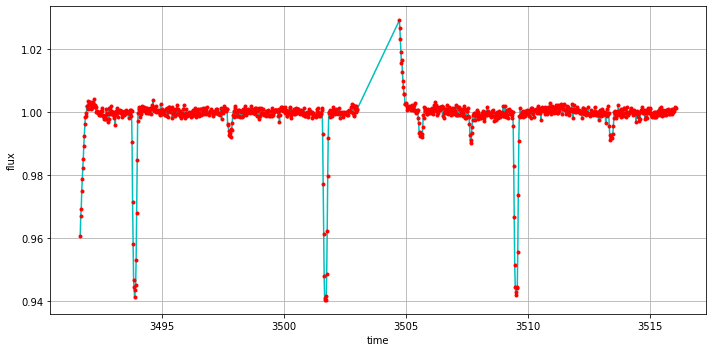

/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200_SEC010_LC.txt


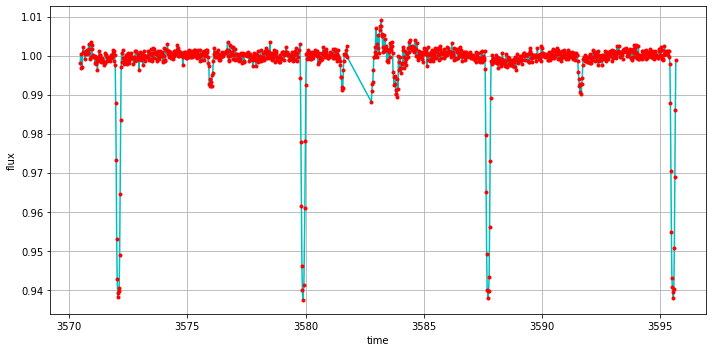

/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200_SEC011_LC.txt


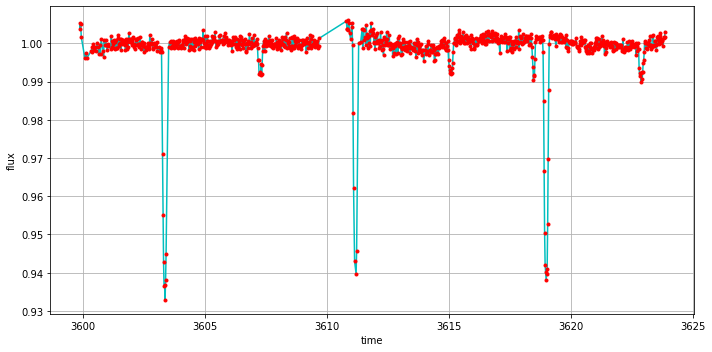

/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200_SEC013_LC.txt


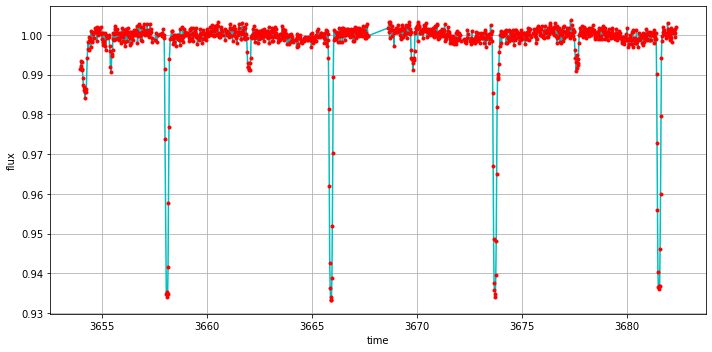

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [6]:
# tic00041088200
tic00041088200 =  glob("/Users/laote/sdsu/Research/binary/curve_bin/Binary_good/tic00041088200*.txt")
tic00041088200 = sorted(tic00041088200, key=lambda name: int(name[-25:-14] + name[-10:-7]))
for tic in tic00041088200:
    print(tic)
    t200, f200, et200 = light_curve(tic,look=True)
t200, f200, et200 = mulit_light_curve(tic)

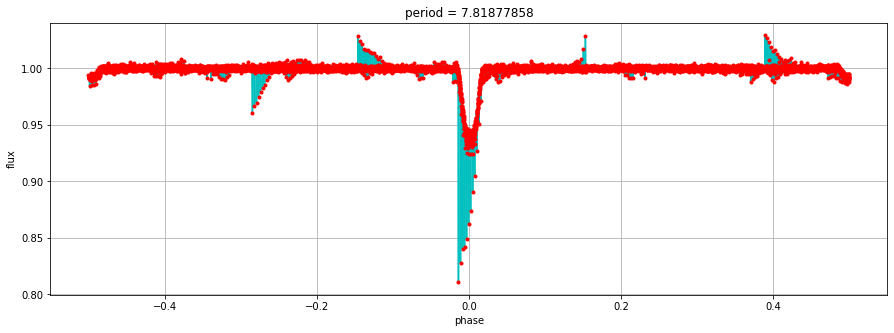

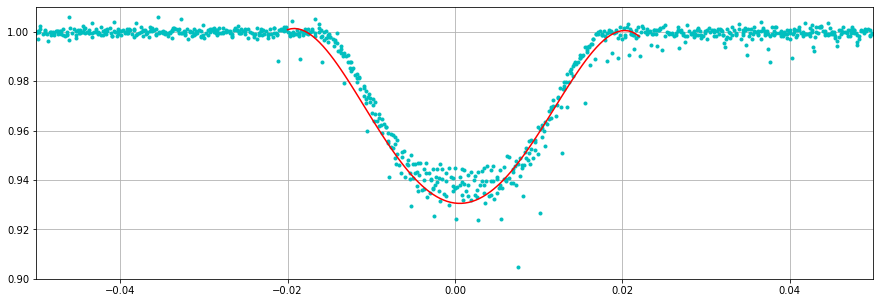

array([-4.63707081e+05,  1.01710595e+03,  3.60441646e+02, -4.16839125e-01,
        9.30640481e-01])

In [7]:
S200,x200,y200 = sing_dc_func(7.81877858,t200,f200,3360.962142,look=True)
w = (x200 > -0.02) & (x200 < 0.022)
popt, pcov = curve_fit(fourth_poly, x200[w], y200[w])
pe_cod = popt

testx = np.linspace(-0.02,0.022,100)
testy = fourth_poly(testx,popt[0],popt[1],popt[2],popt[3],popt[4])


plt.figure(figsize=(15,5))    
plt.plot(x200,y200,'c.')
plt.plot(testx,testy,'r')
plt.xlim(-0.05,0.05)
plt.ylim(0.9,1.01)
plt.grid()
plt.show()
pe_cod

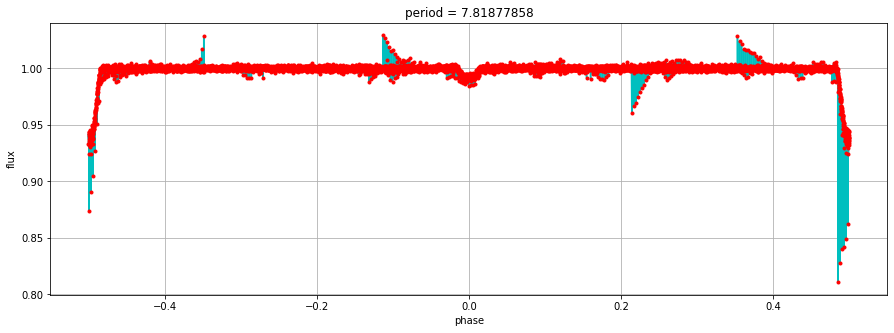

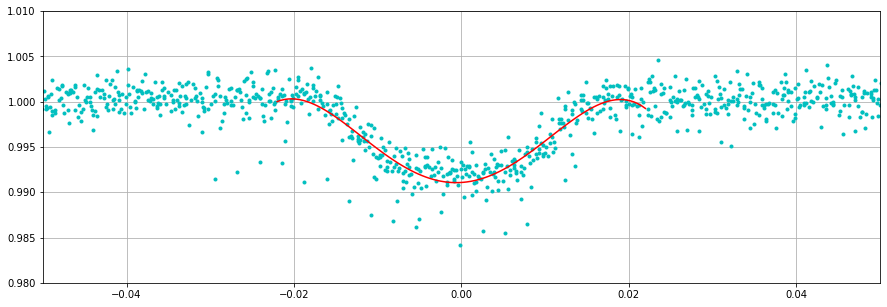

In [8]:
S200,x200,y200 = sing_dc_func(7.81877858,t200,f200,3325.79,look=True)
w = (x200 > -0.022) & (x200 < 0.022)
popt, pcov = curve_fit(fourth_poly, x200[w], y200[w])
ps_cod = popt

testx = np.linspace(-0.022,0.022,100)
testy = fourth_poly(testx,popt[0],popt[1],popt[2],popt[3],popt[4])


plt.figure(figsize=(15,5))    
plt.plot(x200,y200,'c.')
plt.plot(testx,testy,'r')
plt.xlim(-0.05,0.05)
plt.ylim(0.98,1.01)
plt.grid()
plt.show()

In [16]:
prim_eci = [3329.69609053, 3337.52034627, 3345.33930266, 3360.96214225,
        3368.79971065, 3376.6102663 , 3392.24823079, 3400.06757029,
        3415.70444644, 3431.34329992, 3439.16003809, 3446.98163268,
        3454.79983502, 3462.61511311, 3470.43454   , 3486.07251003,
        3493.8821324 , 3501.71037936, 3509.53304525, 3525.16774297,
        3540.81478703, 3572.07897242, 3579.89528334, 3587.71696059, 3595.54,
        3603.34960334, 3611.17072216, 3618.99278497, 3658.08951979,
        3665.9035566 , 3673.72085485, 3681.54087848]
sec_eci = [3325.89, 3333.79, 3341.66, 3357.14, 3365.01, 3372.84,
        3380.56, 3388.53, 3404.09, 3411.85, 3427.45, 3435.39,
        3443.17, 3458.82, 3474.39, 3482.17, 3497.87, 3505.85, 
        3513.41, 3521.35, 3576.06, 3583.92, 3591.76, 3607.32,
        3615.14, 3622.95, 3662.14, 3669.84, 3677.71]

third_eci = [3341.44, 3360.21, 3378.49, 3397.02, 3415.14, 3433.82,
        3452.40, 3471.00, 3489.21, 3507.72, 3526.16,
        3581.59, 3618.48, 3655.43, 3673.88]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


ValueError: num must be 1 <= num <= 9, not 11

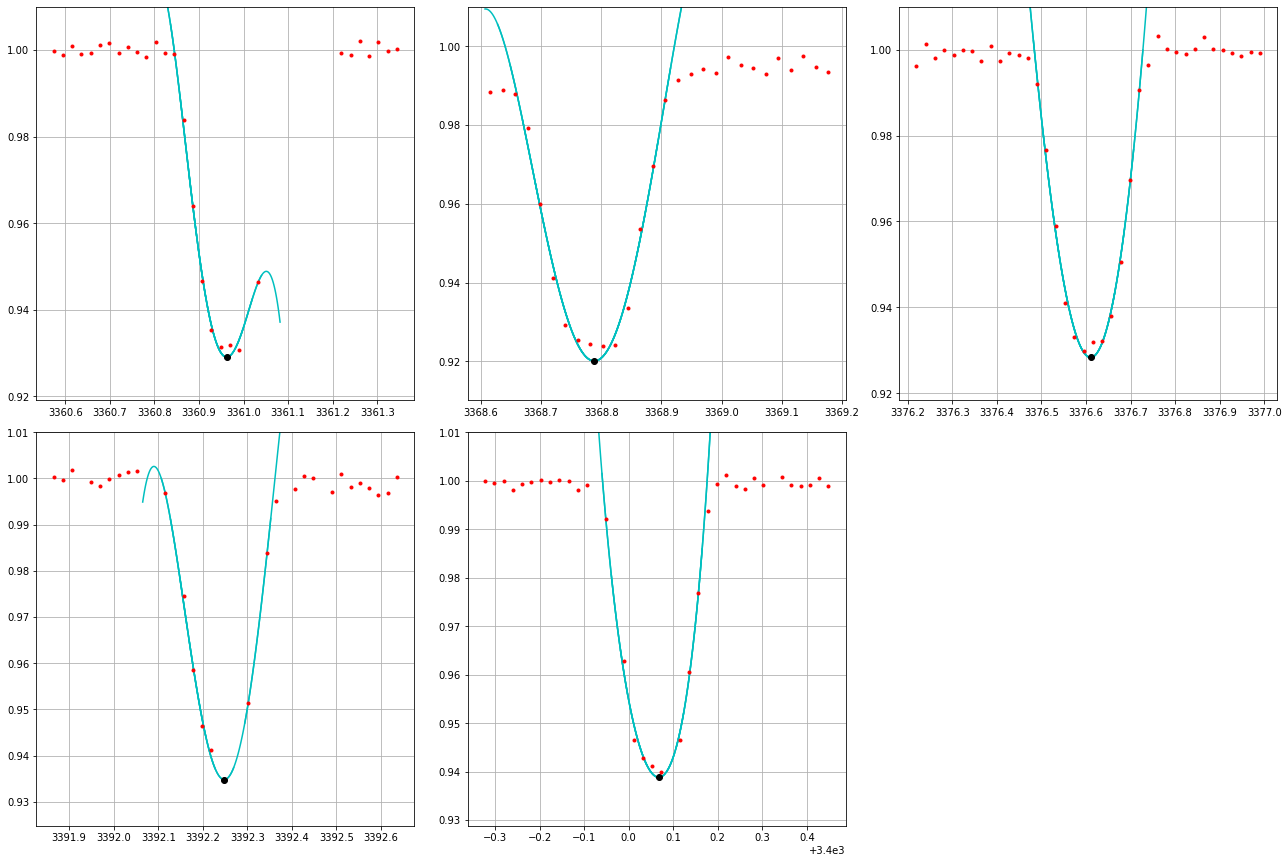

In [15]:
# prim_eci = [3587.71696059, 3595.54,
#         3603.34960334, 3611.17072216, 3618.99278497, 3658.08951979,
#         3665.9035566 , 3673.72085485, 3681.54087848]
prim_time = find_eclipse_single(tic00041088200[0],7.8187447,prim_eci,True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


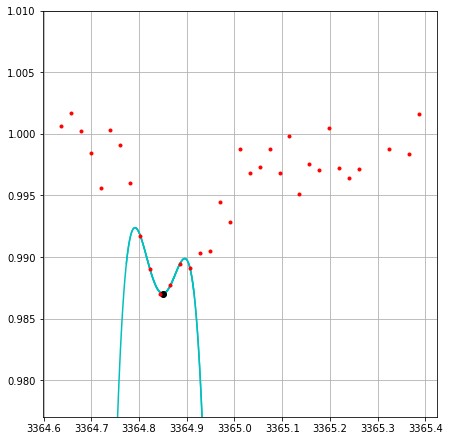

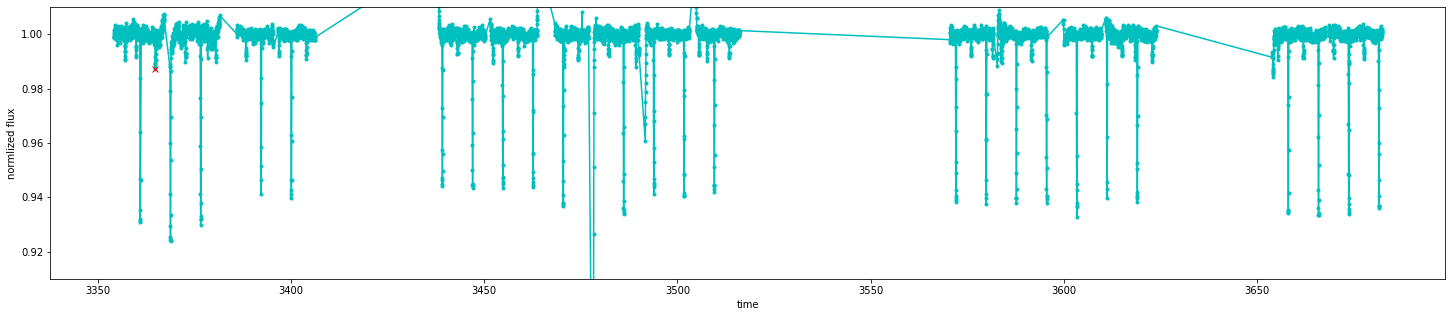

In [11]:
sec_time = find_eclipse_single(tic00041088200[0],7.8187447,sec_eci,True)

In [12]:
third_time = find_eclipse_single(tic00041088200[0],7.8187447,third_eci,True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


ValueError: num must be 1 <= num <= 9, not 15

<Figure size 864x864 with 0 Axes>

In [ ]:
# del_sec = np.array([4,7,10,16,19,20,22,26,29])-1
# new_sec_time = np.delete(sec_time,del_sec)
prim_time = np.array(prim_time);sec_time = np.array(sec_time);third_time = np.array(third_time)
phip, Ip = Phase_cycle(prim_time,7.81877858, 3329.69622237)
phis, Is = Phase_cycle(sec_time,7.81892565, 3325.78255901)
phit, It = Phase_cycle(third_time,18.46908925, 3359.91929791)

plt.figure(figsize=(15,5))
plt.plot(prim_time,phip,'r.-')
plt.plot(sec_time,phis,'c.-')
plt.plot(third_time,phit,'b.-')
plt.xlabel('time');plt.ylabel('phase diff')
plt.grid()
plt.show()

OC_p = prim_time - 3329.69622237 - Ip*7.81877858
OC_s = sec_time - 3325.78255901 - Is*7.81892565
OC_t = third_time - 3359.92025899 - It*18.46898996 


plt.figure(figsize=(15,5))
plt.plot(prim_time,OC_p*1440,'ro-')
plt.plot(sec_time,OC_s*1440,'co-')
plt.plot(third_time[:-1],OC_t[:-1]*1440,'bo-')
plt.xlabel('time (BJD -2,455,000)');plt.ylabel('O-C (min)')
plt.grid()
plt.show()

In [ ]:
popt, pcov = curve_fit(first_poly, Ip, prim_time)
print(popt,np.sqrt(pcov[0,0]),np.sqrt(pcov[1,1]))
popt, pcov = curve_fit(first_poly, Is, sec_time)
print(popt,np.sqrt(pcov[0,0]),np.sqrt(pcov[1,1]))
popt, pcov = curve_fit(first_poly, It[:-1], third_time[:-1])
print(popt,np.sqrt(pcov[0,0]),np.sqrt(pcov[1,1]))

In [538]:
time_comb = np.append(prim_time,sec_time)
phic, Ic = Phase_cycle(time_comb,7.81877858/2, 3329.69622237)
popt, pcov = curve_fit(first_poly, Ic, time_comb)
print(popt,np.sqrt(pcov[0,0]),np.sqrt(pcov[1,1]))

[   3.90940365 3329.69450719] 7.827543953461212e-05 0.0038860205104686136


In [539]:
3.90942633*2,7.802810381116559e-05*2

(7.81885266, 0.00015605620762233118)

In [519]:
# 3341.4461320726127 has both secondary and third ecilpse

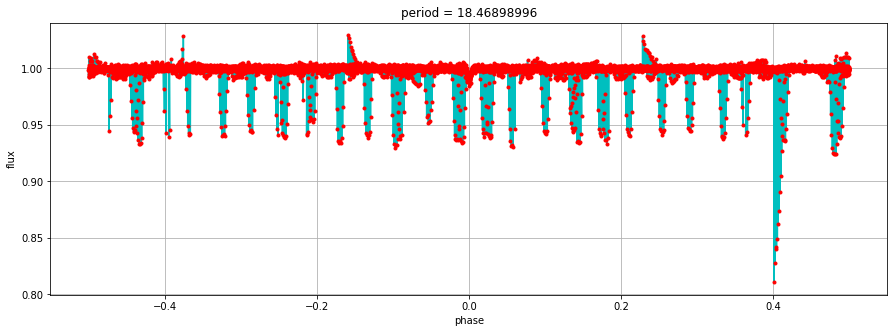

(-0.856530344407683,
 array([-0.4999809 , -0.49995062, -0.49992146, ...,  0.49953349,
         0.49956778,  0.49995676]),
 array([0.99897393, 0.99252516, 0.99778273, ..., 0.99879686, 0.99946111,
        0.99932336]))

In [591]:
sing_dc_func(18.46898996,t200,f200,3359.92025899,look=True)

In [592]:
# /home/orosz/TESS/lightcurves/binaries01/Curves2